<a href="https://colab.research.google.com/github/Madiha64/Madiha-CV-cat-dog-cnn/blob/main/colorization_autoencoder_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
""" Convert from color image (RGB) to grayscale.
Source: opencv.org
grayscale = 0.299*red + 0.587*green + 0.114*blue
Argument:
rgb (tensor): rgb image
Return:
(tensor): grayscale image
"""


' Convert from color image (RGB) to grayscale.\nSource: opencv.org\ngrayscale = 0.299*red + 0.587*green + 0.114*blue\nArgument:\nrgb (tensor): rgb image\nReturn:\n(tensor): grayscale image\n'

In [4]:
# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()
# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


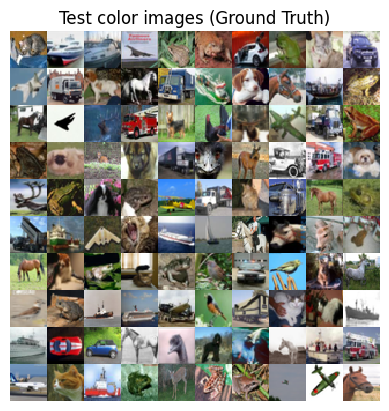

In [5]:
# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

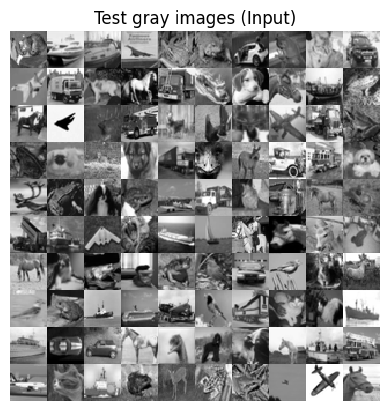

In [6]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)
# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [7]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255
# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,
                          channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows,
img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)
# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [8]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
  x = Conv2D(filters=filters,kernel_size=kernel_size,strides=2,activation='relu',padding='same')(x)
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have thisshape
# shape is (4, 4, 256) which is processed by the decoder back to (32,32, 3)
shape = K.int_shape(x) # When working with Keras (especially in custom layers or Lambda layers), we often need to know the dimensions of a tensor.
# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 256)            │     1,048,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,418,496 (5.41 MB)

 Trainable params: 1,418,496 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=2,activation='relu',padding='same')(x)
outputs = Conv2DTranspose(filters=channels,kernel_size=kernel_size,activation='sigmoid',padding='same',name='decoder_output')(x)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)),
name='autoencoder')
autoencoder.summary()
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
cooldown=0,
patience=5,
verbose=1,
min_lr=0.5e-6)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 32, 32, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,013,315 (7.68 MB)

 Trainable params: 2,013,315 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 256)            │     1,418,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │     2,013,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,431,811 (13.09 MB)

 Trainable params: 3,431,811 (13.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
monitor='val_loss',
verbose=1,
save_best_only=True)
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')
# called every epoch
callbacks = [lr_reducer, checkpoint]
# train the autoencoder
autoencoder.fit(x_train_gray,x_train,
                validation_data=(x_test_gray, x_test),
                 epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0226
Epoch 1: val_loss improved from inf to 0.01090, saving model to /content/saved_models/colorized_ae_model.001.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 545s 346ms/step - loss: 0.0226 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0105
Epoch 2: val_loss improved from 0.01090 to 0.00977, saving model to /content/saved_models/colorized_ae_model.002.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 558s 344ms/step - loss: 0.0105 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0093
Epoch 3: val_loss improved from 0.00977 to 0.00904, saving model to /content/saved_models/colorized_ae_model.003.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 558s 341ms/step - loss: 0.0093 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0087
Epoch 4: val_loss improved from 0.00904 to 0.00835, saving model to /content/saved_models/colorized_ae_model.004.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 527s 337ms/step - loss: 0.0087 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0083
Epoch 5: val_loss improved from 0.00835 to 0.00816, saving model to /content/saved_models/colorized_ae_model.005.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 569s 341ms/step - loss: 0.0083 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0080
Epoch 6: val_loss improved from 0.00816 to 0.00810, saving model to /content/saved_models/colorized_ae_model.006.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 534s 341ms/step - loss: 0.0080 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0077
Epoch 7: val_loss improved from 0.00810 to 0.00791, saving model to /content/saved_models/colorized_ae_model.007.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 567s 345ms/step - loss: 0.0077 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0074
Epoch 8: val_loss did not improve from 0.00791
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 556s 341ms/step - loss: 0.0074 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 9/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0072
Epoch 9: val_loss improved from 0.00791 to 0.00775, saving model to /content/saved_models/colorized_ae_model.009.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 566s 344ms/step - loss: 0.0072 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 10/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0069
Epoch 10: val_loss improved from 0.00775 to 0.00770, saving model to /content/saved_models/colorized_ae_model.010.h5


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 556s 340ms/step - loss: 0.0069 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 11/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0067
Epoch 11: val_loss did not improve from 0.00770
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 561s 340ms/step - loss: 0.0067 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 12/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0064
Epoch 12: val_loss did not improve from 0.00770
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 558s 337ms/step - loss: 0.0064 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 13/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0062
Epoch 13: val_loss did not improve from 0.00770
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 570s 342ms/step - loss: 0.0062 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 14/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0059
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.

Epoch 14: val_loss did not improve from 0.00770
1563/1563 ━━━━━━━━━━━

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 561s 340ms/step - loss: 0.0053 - val_loss: 0.0075 - learning_rate: 3.1623e-04
Epoch 16/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0049
Epoch 16: val_loss did not improve from 0.00749
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 559s 338ms/step - loss: 0.0049 - val_loss: 0.0076 - learning_rate: 3.1623e-04
Epoch 17/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0048
Epoch 17: val_loss did not improve from 0.00749
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 561s 337ms/step - loss: 0.0048 - val_loss: 0.0076 - learning_rate: 3.1623e-04
Epoch 18/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.0046
Epoch 18: val_loss did not improve from 0.00749
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 556s 334ms/step - loss: 0.0046 - val_loss: 0.0077 - learning_rate: 3.1623e-04
Epoch 19/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0045
Epoch 19: val_loss did not improve from 0.00749
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 576s 343ms/step - loss: 0.0045 - val_loss: 0.0076 - l